In [3]:
from dotenv import load_dotenv
load_dotenv()

True

# Download chinookbook

In [4]:
import requests

url = "https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/refs/heads/master/db_samples/Chinook.db"
response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as f:
        f.write(response.content)
else:
    print("Failed to download the file")



# LLM Conncection 


In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [6]:
db.dialect

'sqlite'

In [7]:
print(db.get_usable_table_names())

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [8]:
db.run("SELECT * FROM album LIMIT 5")

"[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2), (3, 'Restless and Wild', 2), (4, 'Let There Be Rock', 1), (5, 'Big Ones', 3)]"

# LLM Connection 

In [9]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="qwen2.5",base_url="http://localhost:11434")

#llm = ChatOllama(model="qwen:4b",base_url="http://localhost:11434")
llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-19T05:37:50.4260163Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 4223376600, 'load_duration': 47318200, 'prompt_eval_count': 30, 'prompt_eval_duration': 1322609300, 'eval_count': 10, 'eval_duration': 2852283900}, id='run--d0cd1695-62f3-482b-a0e5-21a7d229c547-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

# Application state

In [10]:
from typing import TypedDict,Annotated

class State(TypedDict):
    question:str #user question
    query:str #sql query
    result:str #result of query
    answer:str #answer to user question


In [11]:

from langchain import hub

query_prompt = hub.pull("langchain-ai/sql-query-system-prompt")

c:\Users\aryan.katoch\AppData\Local\anaconda3\envs\langgraph\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [12]:
query_prompt.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}


## Write,Execute and generate SQL response

# `Write` Node for SQL query 

In [13]:
from typing import Annotated

class QueryOutput(TypedDict):
    """
    Generated SQL query
    """
    query: Annotated[str,...,"Syntactically correct and valid SQL query"]

QueryOutput({"query":"SELECT * FROM album LIMIT 5"})
QueryOutput.__annotations__

{'query': typing.Annotated[str, Ellipsis, 'Syntactically correct and valid SQL query']}

In [14]:

def write_query(state:State):
    """
    Generate SQL query to fetch information 
    """
    prompt = query_prompt.invoke({
        "dialect":db.dialect,
        "top_k":5,
        "table_info":db.table_info,
        "input":state["question"]
    })

    structured_llm = llm.with_structured_output(QueryOutput)

    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}
write_query({"question":"What are the top 5 albums?"})

{'query': 'SELECT Title FROM Album ORDER BY AlbumId LIMIT 5'}

# execute sql query from user question

In [15]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state:State):
    """ Execeute SQL query and return the result"""
    query = state["query"]
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    
    return {'result': execute_query_tool.invoke({"query":query})}

execute_query({"query":"SELECT * FROM album LIMIT 5"})

{'result': "[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2), (3, 'Restless and Wild', 2), (4, 'Let There Be Rock', 1), (5, 'Big Ones', 3)]"}

# Generate Answer

In [16]:
def generate_answer(state:State):
    """Generate answer using retreived information as the context"""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)

    return {"answer": response.content}

In [17]:
question = "how many employees are there"
query = write_query({"question": question})
query

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee'}

In [18]:
result = execute_query(query)
result

{'result': '[(8,)]'}

In [19]:
state = {"question": question, **query, **result}
state


{'question': 'how many employees are there',
 'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee',
 'result': '[(8,)]'}

In [20]:
generate_answer(state)

{'answer': 'Based on the SQL result provided, there are 8 employees in total. The `COUNT(*)` function returned a count of 8 rows from the `Employee` table, which corresponds to the number of employees.'}

# Building Graph 

In [21]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

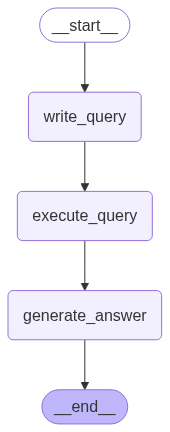

In [22]:
graph_builder = StateGraph(State)

graph_builder.add_node("write_query",write_query)
graph_builder.add_node("execute_query",execute_query)
graph_builder.add_node("generate_answer",generate_answer)

graph_builder.add_edge(START,"write_query")
graph_builder.add_edge("write_query","execute_query")
graph_builder.add_edge("execute_query","generate_answer")
graph_builder.add_edge("generate_answer",END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
query={'question':'list all albums'}
for step in graph.stream(query,stream_mode="updates"):
    print(step)


{'write_query': {'query': 'SELECT Title FROM Album LIMIT 5'}}
{'execute_query': {'result': "[('For Those About To Rock We Salute You',), ('Balls to the Wall',), ('Restless and Wild',), ('Let There Be Rock',), ('Big Ones',)]"}}
{'generate_answer': {'answer': 'The SQL query executed retrieves the titles of albums, limiting the results to the first 5. Based on the provided result, here are the first five album titles listed:\n\n1. For Those About To Rock We Salute You\n2. Balls to the Wall\n3. Restless and Wild\n4. Let There Be Rock\n5. Big Ones\n\nIf you need more albums listed or any other details about these albums, feel free to ask!'}}


# LangGraph agents

In [24]:
from langchain import hub

prompt = hub.pull("langchain-ai/sql-query-system-prompt")
prompt.messages[0].pretty_print()

c:\Users\aryan.katoch\AppData\Local\anaconda3\envs\langgraph\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}


In [25]:
# Current problematic code
# system_prompt = prompt.invoke({'dialect':db.dialect,'top_k':5})

# Fix: Add the required table_info parameter and input parameter
system_prompt = prompt.invoke({
    'dialect': db.dialect,
    'top_k': 5,
    'table_info': db.table_info,
    'input': ''  # Add an empty input or your specific question
})

In [26]:
system_prompt = prompt.format(dialect = db.dialect, top_k=5,table_info=db.table_info,input = '')
system_prompt

'System: Given an input question, create a syntactically correct sqlite query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most 5 results. You can order the results by a relevant column to return the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\n\nOnly use the following tables:\n\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those Abou

In [27]:
from langchain_community.agent_toolkits import  SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db,llm=llm)

In [28]:
toolkit.get_context()

{'table_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"Supp

In [29]:
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002915E4E0CD0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002915E4E0CD0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002915E4E0CD0>),
 QuerySQLCheckerTool(description='Use this tool to 

In [30]:
tools[0].invoke("select * from Album LIMIT 2")

"[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2)]"

In [31]:
print(tools[1].invoke("Album,Customer"))


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")
)

/*
3 rows from Customer table:
CustomerId	FirstName	LastName	Company	Address	City	State	Country	PostalCode	Phone	Fax	Email	SupportRepId
1	Luís	Gonçalves	Embraer 

# Agent Coding

In [32]:
from langgraph.prebuilt import create_react_agent 
from langchain_core.messages import HumanMessage

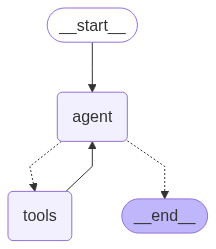

In [33]:
agent_executor = create_react_agent(llm,tools,state_modifier=system_prompt)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [34]:
question = "Which county's customer has made most purchases?"

query={"messages": [HumanMessage(question)]}

for step in agent_executor.stream(query, stream_mode="updates"):
    print(step)
    # step['messages'][-1].pretty_print() 

{'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-19T05:46:40.2741279Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'sql_db_query_checker', 'arguments': {'query': 'SELECT c.Country FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY COUNT(i.InvoiceId) DESC LIMIT 1'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 172927312700, 'load_duration': 37622200, 'prompt_eval_count': 2970, 'prompt_eval_duration': 156368011700, 'eval_count': 54, 'eval_duration': 16507453700}, id='run--7e2455f6-5c1a-469c-84a1-8185f801f367-0', tool_calls=[{'name': 'sql_db_query_checker', 'args': {'query': 'SELECT c.Country FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY COUNT(i.InvoiceId) DESC LIMIT 1'}, 'id': '41941914-ad1e-48b1-ab42-dcefda4146db', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2